<a href="https://colab.research.google.com/github/annapmp/A-B-Testing_-International_Online_Store/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_11_%D0%A3%D1%81%D0%BA%D0%BE%D1%80%D0%B5%D0%BD%D0%B8%D0%B5_%D0%90%D0%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from numpy import cov, linspace
from math import sqrt
from statistics import mean
from numpy.random import normal

import scipy
from scipy import stats
from tqdm.notebook import tqdm

# visual
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Способ 1. Удаление выбросов

In [ ]:
arr = np.random.exponential(1500, size=10000)
arr = np.concatenate([arr, np.zeros(5000)], axis=0)
arr.shape

(15000,)

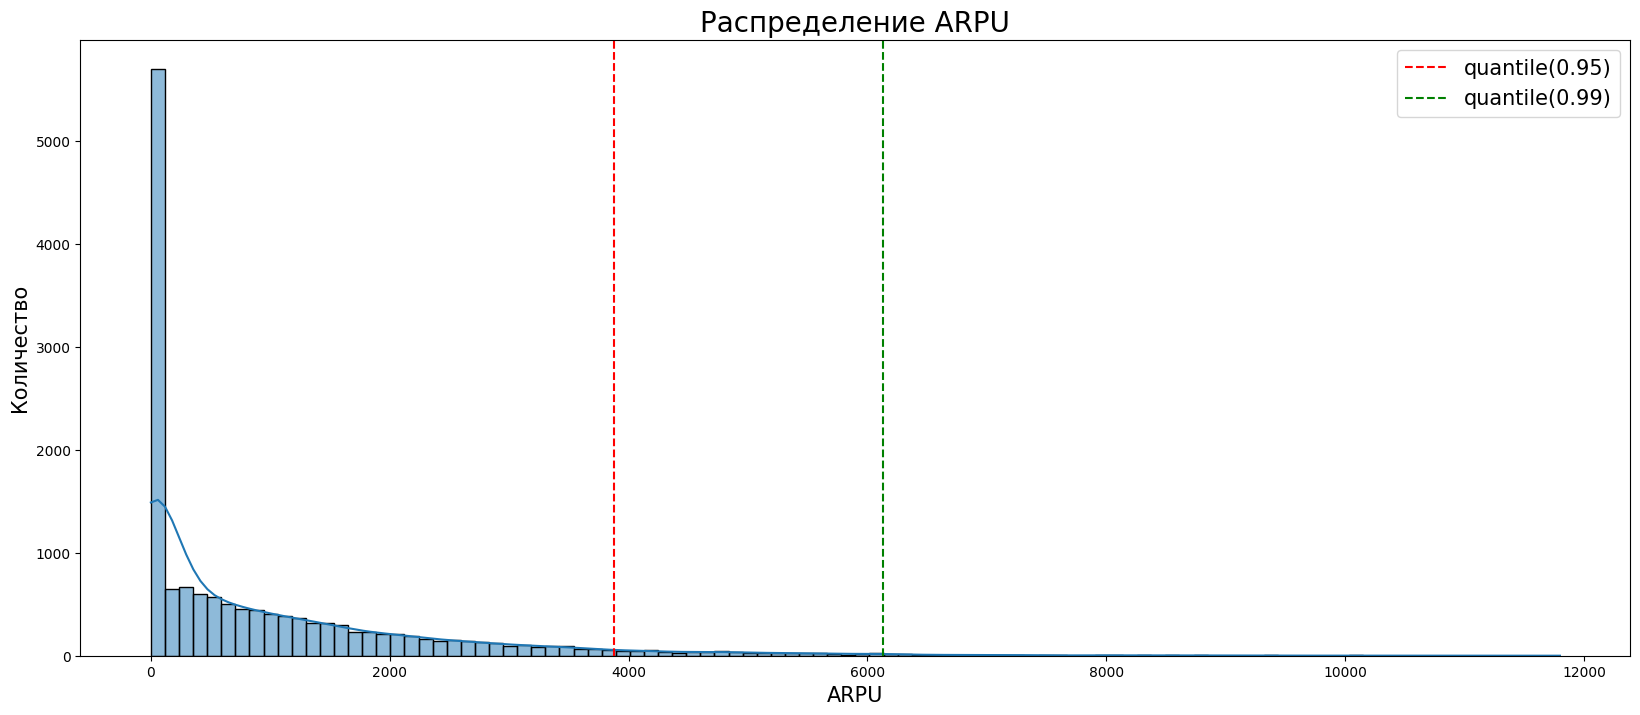

In [ ]:
q = 0.95

plt.figure(figsize=(20, 8))
sns.histplot(arr, bins=100, kde=True)

plt.axvline(np.quantile(arr, q), linestyle="--", label=f'quantile({q})', color = 'r')
plt.axvline(np.quantile(arr, 0.99), linestyle="--", label=f'quantile({0.99})', color = 'g')

# plt.tick_params(axis='x', colors='w')
# plt.tick_params(axis='y', colors='w')
plt.title("Распределение ARPU", fontsize=20)
plt.xlabel("ARPU", fontsize=15)
plt.ylabel("Количество", fontsize=15)
plt.legend(fontsize=15)


In [ ]:
quantiles = np.arange(0.1, 1, 0.1)
quantile_values = np.quantile(arr, quantiles)

df = pd.DataFrame({'Quantile': quantiles, 'Value': quantile_values})
df

,Quantile,Value
0,0.1,0.000000
1,0.2,0.000000
2,0.3,0.000000
3,0.4,170.195197
4,0.5,447.196216
5,0.6,790.875455
6,0.7,1219.647914
7,0.8,1821.875346
8,0.9,2855.969707


In [ ]:
q = 0.95
var_first = round(arr.var())
var_delete = round(arr[arr < np.quantile(arr, q)].var())
var_replace = round(np.where(arr < np.quantile(arr, q), arr, np.quantile(arr, q)).var())

print(f"Var: {var_first}")
print(f"Var (delete quantile-{q}): {var_delete} -> Reduce: {round(1 - var_delete / var_first, 2) * 100}%")
print(f"Var: {var_replace}, Reduce: {round(1 - var_replace / var_first, 2) * 100}%")

Var: 1952484
Var (delete quantile-0.95): 927351 -> Reduce: 53.0%
Var: 1336235, Reduce: 32.0%


# Способ 2. Стратификация

In [ ]:
def generate_strata_data(treatment_effect, size):
    # for each strata, generate y from a normal distribution
    df1 = pd.DataFrame({'strata': 1, 'pre_experient_variance':1, 'y': np.random.normal(loc=10, scale=1, size=size)})
    df2 = pd.DataFrame({'strata': 2, 'pre_experient_variance':2, 'y': np.random.normal(loc=15, scale=2, size=size)})
    df3 = pd.DataFrame({'strata': 3, 'pre_experient_variance':3, 'y': np.random.normal(loc=20, scale=3, size=size)})
    df4 = pd.DataFrame({'strata': 4, 'pre_experient_variance':4, 'y': np.random.normal(loc=25, scale=4, size=size)})
    df = pd.concat([df1, df2, df3, df4])
    # random assign rows to two groups 0 and 1
    df['group'] = np.random.randint(0,2, df.shape[0])
    # for treatment group add a treatment effect
    df.loc[df["group"] == 1, 'y'] += treatment_effect
    return df

def meandiff(df):
    return df[df['group'] == 1]['y'].mean() - df[df['group'] == 0]['y'].mean()

def strata_meandiff(df):
    get_sum = 0
    for i in df.strata.unique():
        get_sum += meandiff(df[df.strata==i])
    return get_sum/len(df.strata.unique())


In [ ]:
df = generate_strata_data(treatment_effect=1, size=100)
df = df.drop('pre_experient_variance', axis=1)
df

,strata,y,group
0,1,10.593391,0
1,1,12.027088,1
2,1,10.476561,1
3,1,8.581767,0
4,1,10.733905,0
...,...,...,...
95,4,25.927090,1
96,4,30.177965,0
97,4,28.117579,0
98,4,21.611027,1


In [ ]:
df.groupby(['group', 'strata']).agg({'y': 'mean'})

y
group strata           
0     1       10.236645
      2       14.523972
      3       20.063053
      4       25.499529
1     1       11.083784
      2       16.020373
      3       21.125824
      4       25.698463

  0%|          | 0/100 [00:00<?, ?it/s]

Original A/B testing, mean = 1.04, variance = 0.26
Strat A/B testing, mean = 0.99, variance = 0.07
Strat Var / Var = 0.27


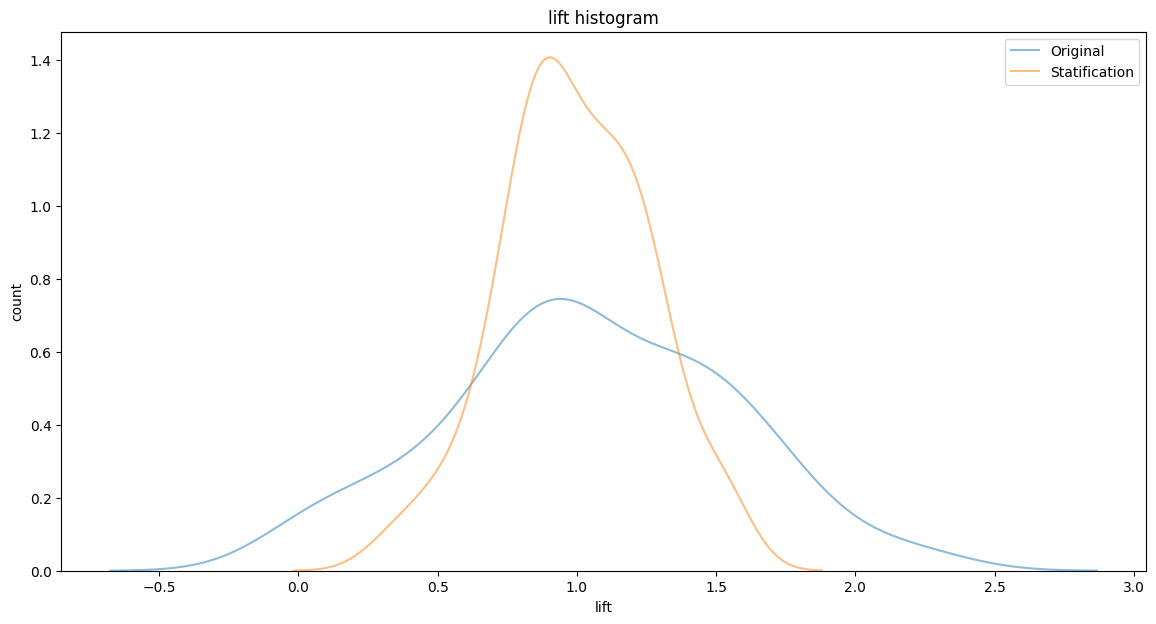

In [ ]:
meandiff_lst = []
strata_meandiff_lst = []
for i in tqdm(range(100)):
    df = generate_strata_data(treatment_effect=1, size=100)
    meandiff_lst.append(meandiff(df))
    strata_meandiff_lst.append(strata_meandiff(df))

orig_mean = np.array(meandiff_lst).mean()
orig_var = np.array(meandiff_lst).var()
strat_mean = np.array(strata_meandiff_lst).mean()
strat_var = np.array(strata_meandiff_lst).var()

print(f'Original A/B testing, mean = {orig_mean:.2f}, variance = {orig_var:.2f}')
print(f'Strat A/B testing, mean = {strat_mean:.2f}, variance = {strat_var:.2f}')
print(f'Strat Var / Var = {(strat_var / orig_var):.2f}')

plt.figure(figsize=(14, 7))
sns.kdeplot(meandiff_lst, alpha=0.5, label='Original')
sns.kdeplot(strata_meandiff_lst, alpha=0.5, label='Statification')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

# Cпособ 3. CUPED
CUPED for conversions: https://github.com/mtrencseni/playground/blob/master/CUPED%20Conversion.ipynb


In [ ]:
def get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N):
    A_before = list(normal(loc=before_mean, scale=before_sigma, size=N))
    B_before = list(normal(loc=before_mean, scale=before_sigma, size=N))
    A_after  = [x + normal(loc=0, scale=eps_sigma) for x in A_before]
    B_after  = [x + normal(loc=0, scale=eps_sigma) + treatment_lift for x in B_before]
    return A_before, B_before, A_after, B_after

def get_cuped_adjusted(A_before, B_before, A_after, B_after):
    cv = cov([A_after + B_after, A_before + B_before])
    theta = cv[0, 1] / cv[1, 1]
    # mean_before = mean(A_before + B_before)   # Для реализации с мат. ожиданием
    A_after_adjusted = [after - (before) * theta for after, before in zip(A_after, A_before)]
    B_after_adjusted = [after - (before) * theta for after, before in zip(B_after, B_before)]
    return A_after_adjusted, B_after_adjusted

# def get_cuped_adjusted_lr(A_before, B_before, A_after, B_after):
#     lr = stats.linregress(A_before + B_before, A_after + B_after)
#     mean_after = mean(A_after + B_after)
#     A_after_adjusted = [mean_after + after - (lr.intercept + before * lr.slope) for after, before in zip(A_after, A_before)]
#     B_after_adjusted = [mean_after + after - (lr.intercept + before * lr.slope) for after, before in zip(B_after, B_before)]
#     return A_after_adjusted, B_after_adjusted

def lift(A, B):
    return mean(B) - mean(A)

def expected_lift_ratio(A_before, B_before, A_after, B_after):
    cv = cov([A_after + B_after, A_before + B_before])
    corr = cv[0, 1] / (sqrt(cv[0, 0]) * sqrt(cv[1, 1]))
    return 1 - corr**2

def p_value(A, B):
    return stats.ttest_ind(A, B)[1]


In [ ]:
N = 1000
before_mean = 100
before_sigma = 50
eps_sigma = 20
treatment_lift = 2

A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N)
A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)

print(f"mean(A_before) = {mean(A_before):.2f}, mean(A_after) = {mean(A_after):.2f}, A_after_cuped = {mean(A_after_adjusted)}")
print(f"mean(B_before) = {mean(B_before):.2f}, mean(B_after) = {mean(B_after):.2f}, B_after_cuped = {mean(B_after_adjusted)}")

print(f'Traditional A/B test evaluation, lift = {lift(A_after, B_after):.3f}, p-value = {p_value(A_after, B_after):.3f}')
print('CUPED adjusted A/B test evaluation, lift = %.3f, p-value = %.3f' % (lift(A_after_adjusted, B_after_adjusted), p_value(A_after_adjusted, B_after_adjusted)))

mean(A_before) = 100.31, mean(A_after) = 99.81, A_after_cuped = 0.21850974282889232
mean(B_before) = 100.25, mean(B_after) = 102.05, B_after_cuped = 2.5128428000644
Traditional A/B test evaluation, lift = 2.234, p-value = 0.342
CUPED adjusted A/B test evaluation, lift = 2.294, p-value = 0.010


  0%|          | 0/1000 [00:00<?, ?it/s]

------------------------
Corr(A_after, A_before):  0.93
Corr(B_after, B_before):  0.93
------------------------
Traditional    A/B testing, mean = 2.04, variance = 5.76
CUPED adjusted A/B testing, mean = 1.97, variance = 0.84
CUPED_var / Var = 0.15


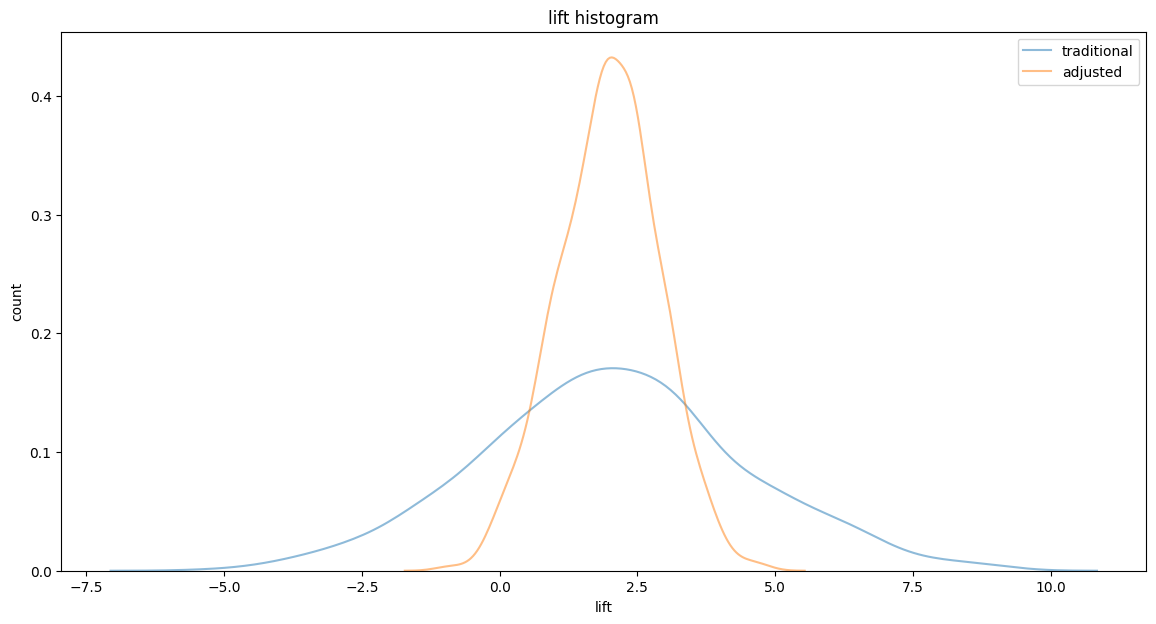

In [ ]:
N = 1000
before_mean = 100
before_sigma = 50
eps_sigma = 20
treatment_lift = 2
num_simulations = 1000


traditional_lifts, adjusted_lifts = [], []
traditional_pvalues, adjusted_pvalues = [], []

for i in tqdm(range(num_simulations)):
    A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N)

    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)

    traditional_lifts.append(lift(A_after, B_after))
    adjusted_lifts.append(lift(A_after_adjusted, B_after_adjusted))
    traditional_pvalues.append(p_value(A_after, B_after))
    adjusted_pvalues.append(p_value(A_after_adjusted, B_after_adjusted))


print("------------------------")
print("Corr(A_after, A_before): ", round(np.corrcoef(A_after, A_before)[1, 0], 2))
print("Corr(B_after, B_before): ", round(np.corrcoef(B_after, B_before)[1, 0], 2))
print("------------------------")

print(f'Traditional    A/B testing, mean = {mean(traditional_lifts):.2f}, variance = {cov(traditional_lifts):.2f}')
print(f'CUPED adjusted A/B testing, mean = {mean(adjusted_lifts):.2f}, variance = {cov(adjusted_lifts):.2f}')
print(f'CUPED_var / Var = {cov(adjusted_lifts)/cov(traditional_lifts):.2f}')

# bins = linspace(-6, 10, 50)
plt.figure(figsize=(14, 7))
sns.kdeplot(traditional_lifts, alpha=0.5, label='traditional')
sns.kdeplot(adjusted_lifts, alpha=0.5, label='adjusted')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

------------------------
Corr(A_after, A_before):  0.0
Corr(B_after, B_before):  0.01
------------------------
Traditional    A/B testing, mean = 1.91, variance = 4.82
CUPED adjusted A/B testing, mean = 1.91, variance = 4.81
CUPED_var / Var = 1.00


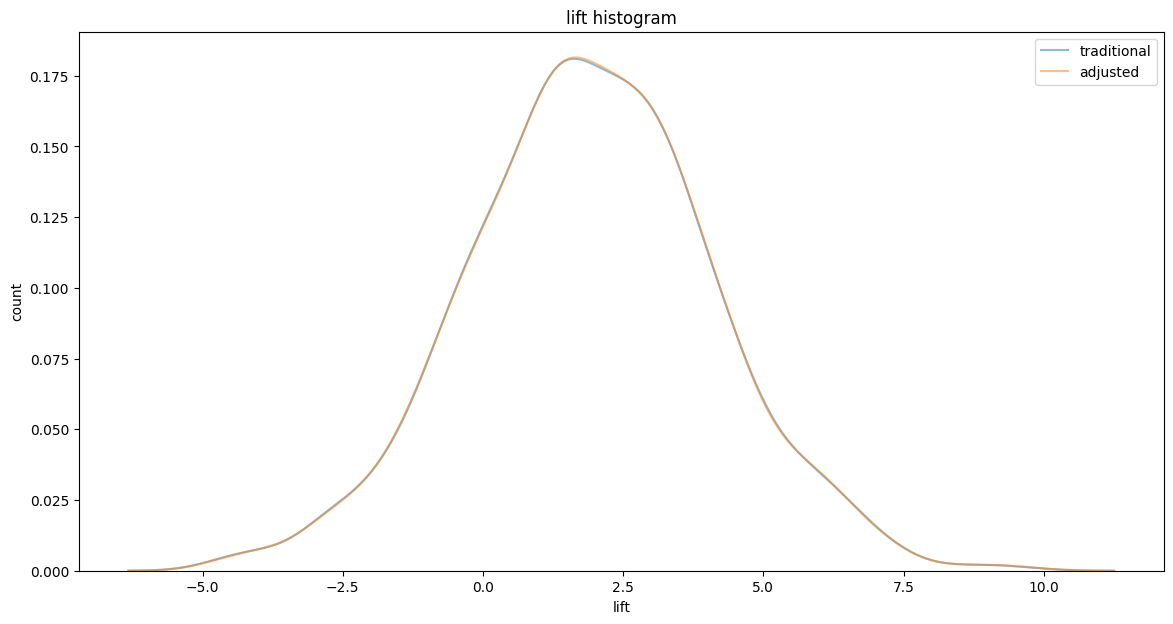

In [ ]:
### no correlation

def get_AB_samples_nocorr(mu, sigma, treatment_lift, N):
    A_before = list(normal(loc=mu, scale=sigma, size=N))
    B_before = list(normal(loc=mu, scale=sigma, size=N))
    A_after  = list(normal(loc=mu, scale=sigma, size=N))
    B_after  = list(treatment_lift + normal(loc=mu, scale=sigma, size=N))
    return A_before, B_before, A_after, B_after

N = 1000
mu = 100
sigma = 50
treatment_lift = 2
num_simulations = 1000


traditional_lifts, adjusted_lifts = [], []
traditional_pvalues, adjusted_pvalues = [], []
for i in tqdm(range(num_simulations)):
    A_before, B_before, A_after, B_after = get_AB_samples_nocorr(mu, sigma, treatment_lift, N)

    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)

    traditional_lifts.append(lift(A_after, B_after))
    adjusted_lifts.append(lift(A_after_adjusted, B_after_adjusted))
    traditional_pvalues.append(p_value(A_after, B_after))
    adjusted_pvalues.append(p_value(A_after_adjusted, B_after_adjusted))

print("------------------------")
print("Corr(A_after, A_before): ", round(np.corrcoef(A_after, A_before)[1, 0], 2))
print("Corr(B_after, B_before): ", round(np.corrcoef(B_after, B_before)[1, 0], 2))
print("------------------------")

print(f'Traditional    A/B testing, mean = {mean(traditional_lifts):.2f}, variance = {cov(traditional_lifts):.2f}')
print(f'CUPED adjusted A/B testing, mean = {mean(adjusted_lifts):.2f}, variance = {cov(adjusted_lifts):.2f}')
print(f'CUPED_var / Var = {cov(adjusted_lifts)/cov(traditional_lifts):.2f}')



plt.figure(figsize=(14, 7))
sns.kdeplot(traditional_lifts, alpha=0.5, label='traditional')
sns.kdeplot(adjusted_lifts, alpha=0.5, label='adjusted')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

# Способ 4. VWE

In [ ]:
def generate_strata_data(treatment_effect, size):
    # for each strata, generate y from a normal distribution
    df1 = pd.DataFrame({'strata': 1, 'pre_experient_variance':1, 'y': np.random.normal(loc=10, scale=1, size=size)})
    df2 = pd.DataFrame({'strata': 2, 'pre_experient_variance':2, 'y': np.random.normal(loc=15, scale=2, size=size)})
    df3 = pd.DataFrame({'strata': 3, 'pre_experient_variance':3, 'y': np.random.normal(loc=20, scale=3, size=size)})
    df4 = pd.DataFrame({'strata': 4, 'pre_experient_variance':4, 'y': np.random.normal(loc=25, scale=4, size=size)})
    df = pd.concat([df1, df2, df3, df4])
    # random assign rows to two groups 0 and 1
    df['group'] = np.random.randint(0,2, df.shape[0])
    # for treatment group add a treatment effect
    df.loc[df["group"] == 1, 'y'] += treatment_effect
    return df

def strata_meandiff(df):
    get_sum = 0
    for i in df.strata.unique():
        get_sum += meandiff(df[df.strata==i])
    return get_sum/len(df.strata.unique())


In [ ]:
def variance_weighted_meandiff(df):
    weighted_effect_sum = 0
    weights_sum = 0
    for i in df.strata.unique():
        #For each strata, we then calculate its average treatment effect
        treatment_effect_strata = meandiff(df[df.strata==i])
        # estimate its weight based on the inverse within-group estimated variance (such as mean)
        weights_strata = 1/df[df.strata==i]['pre_experient_variance'].mean()
        # calculate the sum of weighted treatment effect
        weighted_effect_sum +=  treatment_effect_strata * weights_strata
        # calculate the sum of weights
        weights_sum += weights_strata
    return weighted_effect_sum/weights_sum


  0%|          | 0/1000 [00:00<?, ?it/s]

Original A/B testing, mean = 1.03, variance = 0.37
VWE A/B testing, mean = 1.00, variance = 0.04
VWE Var / Var = 0.10


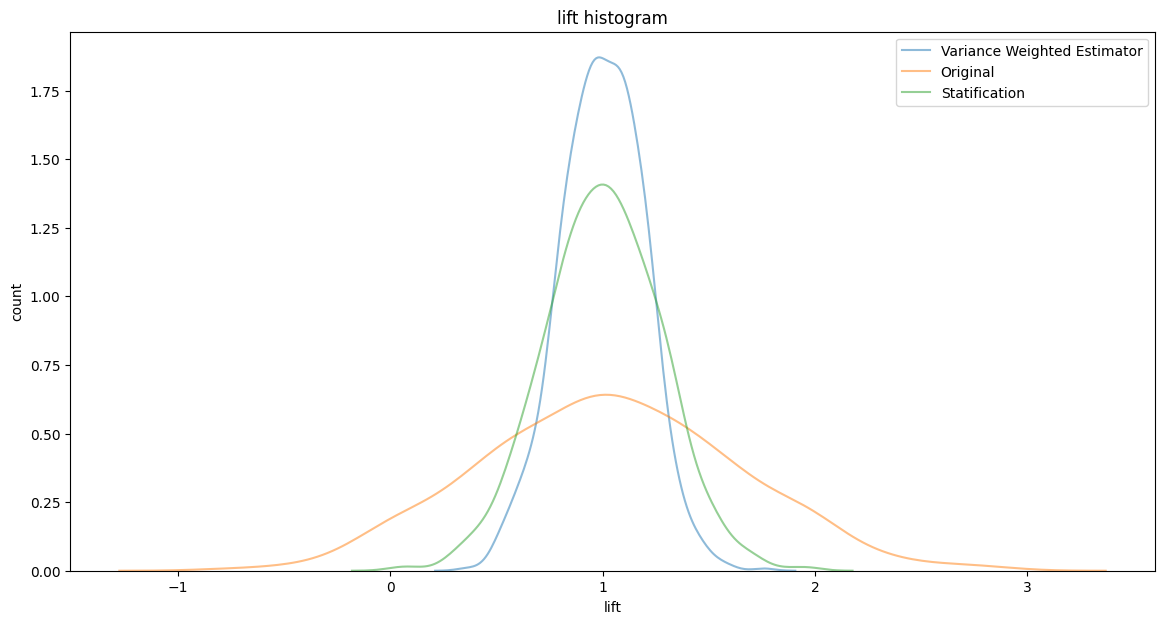

In [ ]:
meandiff_lst = []
variance_weighted_meandiff_lst = []
strata_meandiff_lst = []
for i in tqdm(range(1000)):
    df = generate_strata_data(treatment_effect=1, size=100)
    meandiff_lst.append(meandiff(df))
    variance_weighted_meandiff_lst.append(variance_weighted_meandiff(df))
    strata_meandiff_lst.append(strata_meandiff(df))

orig_mean = np.array(meandiff_lst).mean()
orig_var = np.array(meandiff_lst).var()
vwe_mean = np.array(variance_weighted_meandiff_lst).mean()
vwe_var = np.array(variance_weighted_meandiff_lst).var()

print(f'Original A/B testing, mean = {orig_mean:.2f}, variance = {orig_var:.2f}')
print(f'VWE A/B testing, mean = {vwe_mean:.2f}, variance = {vwe_var:.2f}')
print(f'VWE Var / Var = {(vwe_var / orig_var):.2f}')

plt.figure(figsize=(14, 7))
sns.kdeplot(variance_weighted_meandiff_lst, alpha=0.5, label='Variance Weighted Estimator')
sns.kdeplot(meandiff_lst, alpha=0.5, label='Original')
sns.kdeplot(strata_meandiff_lst, alpha=0.5, label='Statification')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()